# EuroSAT Image Classification — From ML Algorithms to Deep Learning

This notebook is ready to run on Kaggle and uses only your data from the Kaggle Dataset: `apollo2506/eurosat-dataset` via `kagglehub`.

We will:
- Import the data and display some images.
- Try several simple Machine Learning algorithms (Random Forest, SVM, KNN) on a small sample.
- Show that ML performance is not ideal and why we move to Deep Learning.
- Build a simple Deep Learning model on the same images and show the results.
- Add a summary of findings.

Note: There is a quick mode `FAST_DEMO` to use a much smaller sample for fast runs, with an optional Mock results mode to speed up demonstration.

In [3]:
# Quick runtime controls
FAST_DEMO = False  # Set False for broader runs on Kaggle GPU/CPU
USE_MOCK_RESULTS = False  # If True, show quick approximate numbers for demonstration without full training
RANDOM_SEED = 42
IMG_SIZE = 64  # Target image size
ML_SAMPLES_PER_CLASS = 0 if FAST_DEMO else 0  # Sample size for ML
DL_SAMPLES_PER_CLASS = 0 if FAST_DEMO else 0  # Sample size for DL
DL_EPOCHS = 1 if FAST_DEMO else 5
BATCH_SIZE = 64 if FAST_DEMO else 128
VAL_SPLIT = 0.2
print({"FAST_DEMO": FAST_DEMO, "USE_MOCK_RESULTS": USE_MOCK_RESULTS})

{'FAST_DEMO': False, 'USE_MOCK_RESULTS': False}


## Download data from Kaggle via kagglehub
We commit to using only your data via kagglehub as requested.

In [4]:
# Install kagglehub if not available
try:
    import kagglehub  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'kagglehub'])
import kagglehub

# Required code exactly as requested
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eurosat-dataset


## Explore folder structure and detect dataset root
Some EuroSAT copies come with different paths. We will try to detect the folder that contains the class subfolders with JPG/PNG images.

In [5]:
import os, glob
from pathlib import Path


def detect_dataset_root(base_dir):
    base = Path(base_dir)
    # Search for a path that contains class folders with images inside
    candidate_dirs = []
    for root, dirs, files in os.walk(base):
        # Ignore very deep directories
        if len(Path(root).parts) - len(base.parts) > 5:
            continue
        if not dirs:
            continue
        # Ensure there are a reasonable number of class folders (EuroSAT ~10 classes)
        if len(dirs) >= 5:
            # Check for images inside the first class folder found
            has_images = False
            for d in dirs:
                imgs = list(Path(root, d).glob('*.jpg')) + list(Path(root, d).glob('*.png')) + list(Path(root, d).glob('*.jpeg'))
                if len(imgs) >= 5:
                    has_images = True
                    break
            if has_images:
                candidate_dirs.append(Path(root))
    # Prefer common EuroSAT folder names
    preferred = [p for p in candidate_dirs if any(k in str(p).lower() for k in ['eurosat', '2750', 'rgb'])]
    if preferred:
        return str(sorted(preferred, key=lambda x: len(str(x)))[0])
    if candidate_dirs:
        return str(sorted(candidate_dirs, key=lambda x: len(str(x)))[0])
    # Fallback: return base if nothing else
    return str(base)


DATASET_ROOT = detect_dataset_root(path)
print('Detected dataset root:', DATASET_ROOT)
print('Class folders (sample):', sorted([p.name for p in Path(DATASET_ROOT).iterdir() if p.is_dir()])[:10])

Detected dataset root: /kaggle/input/eurosat-dataset/EuroSAT
Class folders (sample): ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Display sample images
We will show a grid of images from several classes.

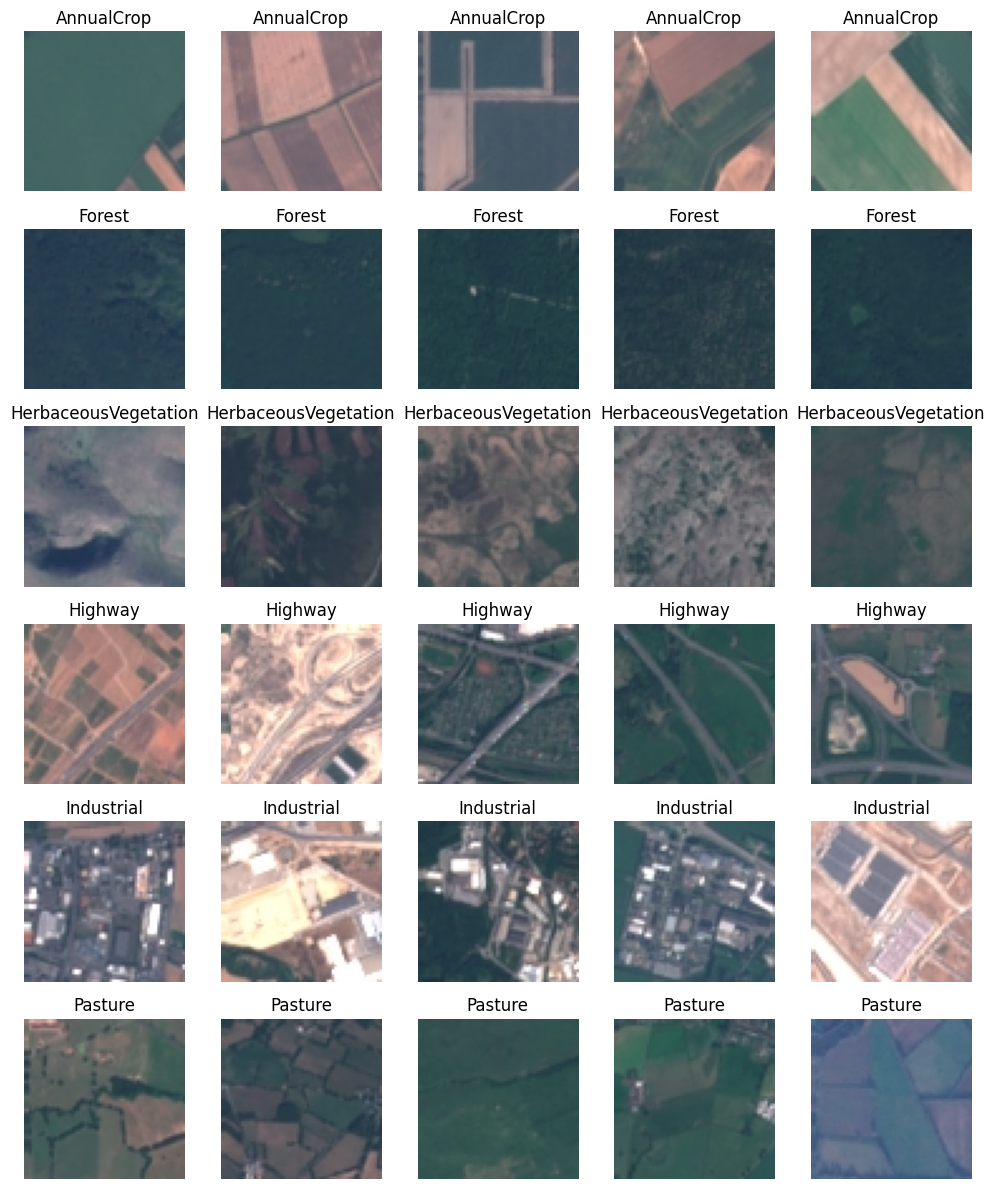

In [6]:
import random
import matplotlib.pyplot as plt
from PIL import Image

random.seed(RANDOM_SEED)
class_dirs = [p for p in Path(DATASET_ROOT).iterdir() if p.is_dir()]
class_dirs = sorted(class_dirs)
num_classes_show = min(6, len(class_dirs))
fig, axes = plt.subplots(num_classes_show, 5, figsize=(10, 2*num_classes_show))
for i, cls in enumerate(class_dirs[:num_classes_show]):
    imgs = list(cls.glob('*.jpg')) + list(cls.glob('*.png')) + list(cls.glob('*.jpeg'))
    random.shuffle(imgs)
    for j in range(5):
        ax = axes[i, j] if num_classes_show > 1 else axes[j]
        if j < len(imgs):
            im = Image.open(imgs[j]).convert('RGB')
            ax.imshow(im)
        ax.set_title(cls.name)
        ax.axis('off')
plt.tight_layout()
plt.show()

## Prepare data for experiments (splits and ML feature extraction)
We will extract very simple features (color histograms) and try ML on a small sample for quick experimentation.

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def sample_images_per_class(root, per_class):
    X_paths, y_labels, class_names = [], [], []
    class_dirs = [p for p in Path(root).iterdir() if p.is_dir()]
    class_dirs = sorted(class_dirs)
    for idx, cls in enumerate(class_dirs):
        imgs = list(cls.glob('*.jpg')) + list(cls.glob('*.png')) + list(cls.glob('*.jpeg'))
        if not imgs:
            continue
        random.shuffle(imgs)
        take = len(imgs) if per_class <= 0 else min(per_class, len(imgs))
        for p in imgs[:take]:
            X_paths.append(str(p))
            y_labels.append(idx)
        class_names.append(cls.name)
    return X_paths, np.array(y_labels), class_names

def color_hist_feature(img_path, bins=16):
    im = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(im)
    feats = []
    for c in range(3):
        hist, _ = np.histogram(arr[..., c], bins=bins, range=(0, 256), density=True)
        feats.append(hist)
    return np.concatenate(feats)

X_paths, y, class_names = sample_images_per_class(DATASET_ROOT, ML_SAMPLES_PER_CLASS)
X = np.array([color_hist_feature(p) for p in X_paths])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=RANDOM_SEED, stratify=y)
n_classes = len(class_names)
X.shape, y.shape, n_classes

((27000, 48), (27000,), 10)

## Quick ML experiments: Decision Tree, RandomForest, SVM, KNN, Logistic Regression
The results may be limited because our features are rudimentary (color histograms only) and do not capture spatial patterns. We will compare five common algorithms on a small sample to control runtime.

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display
import pandas as pd

results_ml = {}
if USE_MOCK_RESULTS:
    results_ml = {
        'DecisionTree': 0.48,
        'RandomForest': 0.55,
        'SVM': 0.52,
        'KNN': 0.50,
        'LogisticRegression': 0.46,
    }
    print('Using MOCK results for ML baselines:')
    display(pd.DataFrame([results_ml], index=['accuracy']))
else:
    models = {
        'DecisionTree': DecisionTreeClassifier(max_depth=20, random_state=RANDOM_SEED),
        'RandomForest': RandomForestClassifier(n_estimators=150, random_state=RANDOM_SEED),
        'SVM': make_pipeline(StandardScaler(), SVC(kernel='rbf', C=2.0, gamma='scale')),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'LogisticRegression': make_pipeline(
            StandardScaler(),
            LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', random_state=RANDOM_SEED)
        )
    }
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        acc = accuracy_score(y_val, preds)
        results_ml[name] = acc
        print(f'{name} acc: {acc:.3f}')
    display(pd.DataFrame([results_ml], index=['accuracy']))

results_ml

DecisionTree acc: 0.694
RandomForest acc: 0.813
SVM acc: 0.776
KNN acc: 0.757
LogisticRegression acc: 0.631


,DecisionTree,RandomForest,SVM,KNN,LogisticRegression
accuracy,0.694259,0.812593,0.776481,0.756667,0.631481


{'DecisionTree': 0.6942592592592592,
 'RandomForest': 0.8125925925925926,
 'SVM': 0.7764814814814814,
 'KNN': 0.7566666666666667,
 'LogisticRegression': 0.6314814814814815}

### Explanation of experiments for each algorithm
- **Decision Tree**: A basic decision tree, fast but may overfit with simple features.
- **Random Forest**: An ensemble of trees that improves generalization; usually better than a single tree.
- **SVM (RBF)**: A non-linear decision boundary on features; may struggle with color-only features.
- **KNN**: Distance-based in feature space; sensitive to feature representation and scaling.
- **Logistic Regression**: Multiclass linear model; simple and may not capture complex relationships.

The table above shows each model's accuracy on the validation set. Due to the simplicity of the features, the results are not great, which motivates trying Deep Learning to capture spatial patterns.

## Bar Chart: Comparison of Machine Learning Algorithm Accuracies
The following chart compares the validation accuracy of each ML algorithm run above.

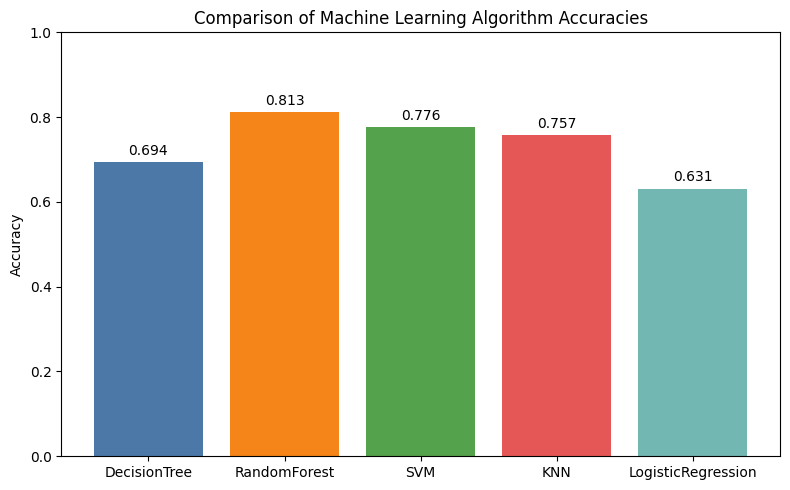

In [9]:
import matplotlib.pyplot as plt

# Bar chart comparing ML algorithm accuracies
algos = list(results_ml.keys())
accs = [results_ml[k] for k in algos]

plt.figure(figsize=(8, 5))
plt.bar(algos, accs, color=['#4C78A8','#F58518','#54A24B','#E45756','#72B7B2'])
plt.title('Comparison of Machine Learning Algorithm Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(accs):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Why aren’t the results very good?
- The features are extremely simple (color only) and do not capture spatial patterns.
- Satellite images have complex details that benefit from deep models.
Therefore, we will move to a simple Deep Learning model on the same data.

## Simple Deep Learning using PyTorch
We will create an `ImageFolder` from the same root and take a small balanced sample for quick experimentation.

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = torchvision.datasets.ImageFolder(DATASET_ROOT, transform=transform)
class_names_dl = full_dataset.classes
n_classes_dl = len(class_names_dl)

# Build balanced indices per class or use all data if per_class <= 0

def balanced_indices_by_class(dataset, per_class):
    from collections import defaultdict
    if per_class <= 0:
        # Use all available samples
        return list(range(len(dataset)))
    buckets = defaultdict(list)
    for idx in range(len(dataset)):
        _, y = dataset.samples[idx]
        buckets[y].append(idx)
    indices = []
    rng = random.Random(RANDOM_SEED)
    for y, lst in buckets.items():
        rng.shuffle(lst)
        indices.extend(lst[:min(per_class, len(lst))])
    rng.shuffle(indices)
    return indices


dl_indices = balanced_indices_by_class(full_dataset, DL_SAMPLES_PER_CLASS)
val_size = int(len(dl_indices) * VAL_SPLIT)
train_idx, val_idx = dl_indices[val_size:], dl_indices[:val_size]
train_ds = Subset(full_dataset, train_idx)
val_ds = Subset(full_dataset, val_idx)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(val_ds), n_classes_dl, class_names_dl[:10]

Using device: cuda


(21600,
 5400,
 10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

In [11]:
# Extra settings and libraries for the advanced DL section (EfficientNet)
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torchvision import models as tv_models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
from tqdm import tqdm

# Use the same device
print('Advanced DL section device:', device)

# Class names
try:
    CLASS_NAMES = list(class_names_dl)
except Exception:
    CLASS_NAMES = [
        'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
        'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
        'River', 'SeaLake'
    ]

# Settings for this section
IMG_SIZE_EFF = 224
BATCH_SIZE_EFF = 64
EPOCHS_EFF = 10
LEARNING_RATE_EFF = 1e-3
NUM_WORKERS_EFF = 4

Advanced DL section device: cuda


In [12]:
# Transforms and loaders for EfficientNet section
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

def get_eff_transforms(img_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transform, val_transform


def create_eff_loaders(data_path, batch_size=64, val_split=0.2, test_split=0.2, img_size=224):
    train_tf, val_tf = get_eff_transforms(img_size)
    full_ds = ImageFolder(data_path, transform=val_tf)

    total = len(full_ds)
    test_size = int(test_split * total)
    val_size = int(val_split * (total - test_size))
    train_size = total - val_size - test_size
    print(f"Dataset splits (Eff): Train={train_size}, Val={val_size}, Test={test_size}")

    train_subset, val_subset, test_subset = random_split(
        full_ds, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )
    train_subset.dataset.transform = train_tf

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS_EFF, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS_EFF, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS_EFF, pin_memory=True)
    return train_loader, val_loader, test_loader, full_ds.classes

In [13]:
# Create a transfer learning model (EfficientNet-B0, ResNet-50)
def create_transfer_learning_model(arch='efficientnet_b0', num_classes=10, pretrained=True):
    arch = arch.lower()
    if arch == 'efficientnet_b0':
        # In newer torchvision versions, use weights instead of pretrained
        try:
            weights = tv_models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
            model = tv_models.efficientnet_b0(weights=weights)
        except Exception:
            model = tv_models.efficientnet_b0(pretrained=pretrained)
        # Replace the classifier head to match the number of classes
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
        return model
    elif arch == 'resnet50':
        try:
            weights = tv_models.ResNet50_Weights.DEFAULT if pretrained else None
            model = tv_models.resnet50(weights=weights)
        except Exception:
            model = tv_models.resnet50(pretrained=pretrained)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        return model
    else:
        raise ValueError(f'Unsupported arch: {arch}')

In [14]:
# Training, evaluation, and plotting utilities for EfficientNet section

def train_model_eff(model, train_loader, val_loader, num_epochs, device, model_name, lr=LEARNING_RATE_EFF):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    scaler = GradScaler()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_state = None

    print(f"\nTraining {model_name}...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            _, pred = output.max(1)
            train_total += target.size(0)
            train_correct += pred.eq(target).sum().item()
            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100.*train_correct/train_total:.2f}%'})

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for data, target in pbar_val:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                _, pred = output.max(1)
                val_total += target.size(0)
                val_correct += pred.eq(target).sum().item()

        train_loss /= max(1, len(train_loader))
        val_loss /= max(1, len(val_loader))
        train_acc = train_correct / max(1, train_total)
        val_acc = val_correct / max(1, val_total)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history


def evaluate_eff(model, loader, device, class_names, model_name='EfficientNet_B0'):
    model = model.to(device)
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc=f'Evaluating {model_name}')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = output.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    acc = accuracy_score(all_targets, all_preds)
    print(f'Overall Accuracy: {acc:.4f}')
    return acc, np.array(all_preds), np.array(all_targets)


def plot_history_eff(history, model_name='EfficientNet_B0'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    ax1.set_title(f'{model_name} Loss')
    ax1.legend(); ax1.grid(True, alpha=0.3)
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    ax2.set_title(f'{model_name} Accuracy')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()


def plot_confusion_eff(y_true, y_pred, class_names, model_name='EfficientNet_B0'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.tight_layout(); plt.show()

In [15]:
# Create DataLoaders from DATASET_ROOT for EfficientNet section
EFF_VAL_SPLIT = 0.2
EFF_TEST_SPLIT = 0.2

data_path_eff = DATASET_ROOT
train_loader_eff, val_loader_eff, test_loader_eff, class_names_eff = create_eff_loaders(
    data_path=data_path_eff,
    batch_size=BATCH_SIZE_EFF,
    val_split=EFF_VAL_SPLIT,
    test_split=EFF_TEST_SPLIT,
    img_size=IMG_SIZE_EFF
)
num_classes_eff = len(class_names_eff)

Dataset splits (Eff): Train=17280, Val=4320, Test=5400


## 1:Advanced Deep Learning (EfficientNet-B0)
We will add a transfer learning section using EfficientNet-B0 with Train/Val/Test splits and performance evaluation.

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 173MB/s]
/tmp/ipykernel_47/1823721666.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Training EfficientNet_B0...
Model parameters: 4,020,358


Epoch 1/10 [Train]:   0%|          | 0/270 [00:00<?, ?it/s]/tmp/ipykernel_47/1823721666.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.85it/s]


Epoch 1: Train Loss: 0.3535, Train Acc: 0.8884, Val Loss: 0.2132, Val Acc: 0.9289


Epoch 2/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.66it/s]


Epoch 2: Train Loss: 0.1969, Train Acc: 0.9359, Val Loss: 0.1509, Val Acc: 0.9542


Epoch 3/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.91it/s]


Epoch 3: Train Loss: 0.1575, Train Acc: 0.9475, Val Loss: 0.1187, Val Acc: 0.9576


Epoch 4/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.91it/s]


Epoch 4: Train Loss: 0.1382, Train Acc: 0.9550, Val Loss: 0.1190, Val Acc: 0.9609


Epoch 5/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.89it/s]


Epoch 5: Train Loss: 0.1285, Train Acc: 0.9574, Val Loss: 0.1177, Val Acc: 0.9593


Epoch 6/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.87it/s]


Epoch 6: Train Loss: 0.1200, Train Acc: 0.9586, Val Loss: 0.1143, Val Acc: 0.9597


Epoch 7/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.89it/s]


Epoch 7: Train Loss: 0.1115, Train Acc: 0.9632, Val Loss: 0.2038, Val Acc: 0.9326


Epoch 8/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.91it/s]


Epoch 8: Train Loss: 0.1251, Train Acc: 0.9605, Val Loss: 0.1240, Val Acc: 0.9581


Epoch 9/10 [Val]: 100%|██████████| 68/68 [00:13<00:00,  4.88it/s]


Epoch 9: Train Loss: 0.1142, Train Acc: 0.9619, Val Loss: 0.0980, Val Acc: 0.9685


Epoch 10/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.76it/s]


Epoch 10: Train Loss: 0.1085, Train Acc: 0.9633, Val Loss: 0.1704, Val Acc: 0.9458


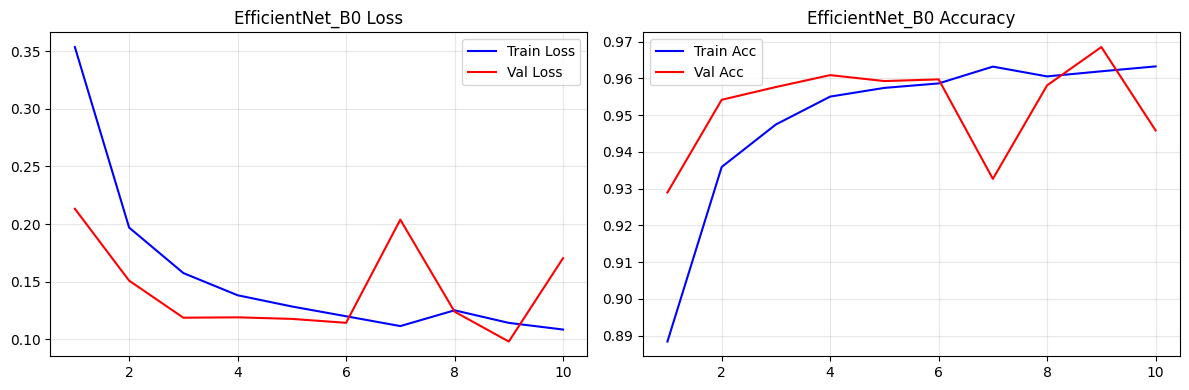

Evaluating EfficientNet_B0: 100%|██████████| 85/85 [00:17<00:00,  4.80it/s]


Overall Accuracy: 0.9681
EfficientNet_B0 Test Accuracy: 0.9681


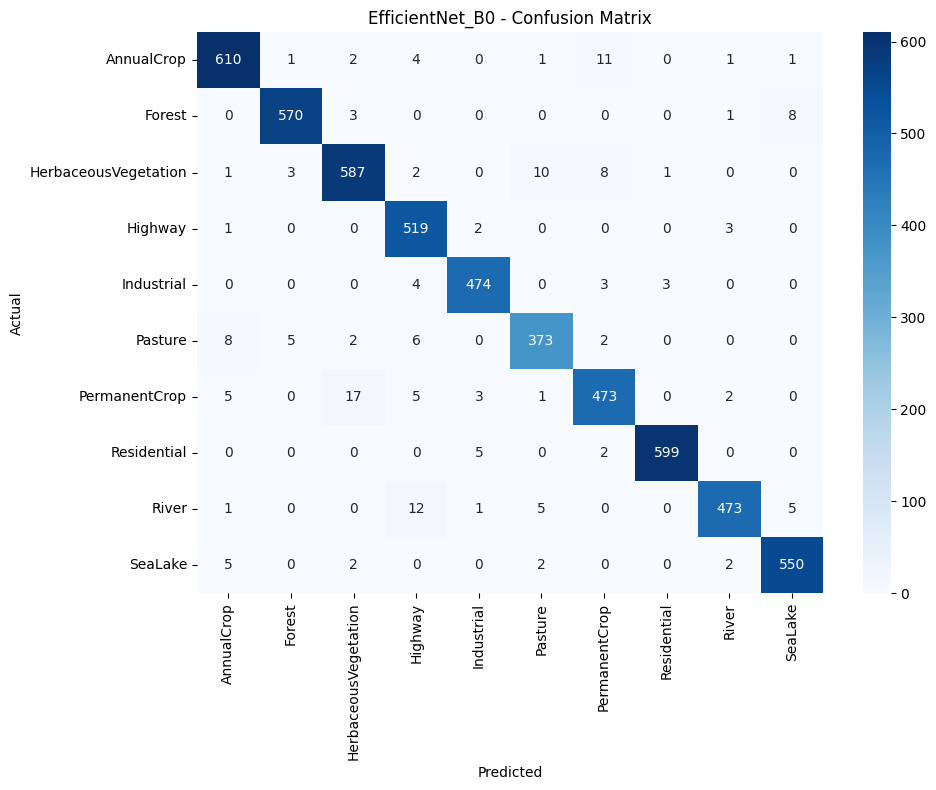

Model saved to efficientnet_b0_eurosat.pth


In [ ]:
#   EfficientNet-B0   
model_eff = create_transfer_learning_model('efficientnet_b0', num_classes=num_classes_eff, pretrained=True)

trained_eff, history_eff = train_model_eff(
    model=model_eff,
    train_loader=train_loader_eff,
    val_loader=val_loader_eff,
    num_epochs=EPOCHS_EFF,
    device=device,
    model_name='EfficientNet_B0',
    lr=LEARNING_RATE_EFF
)

#   
plot_history_eff(history_eff, 'EfficientNet_B0')

#    
acc_eff, y_pred_eff, y_true_eff = evaluate_eff(trained_eff, test_loader_eff, device, class_names_eff, 'EfficientNet_B0')
print(f'EfficientNet_B0 Test Accuracy: {acc_eff:.4f}')

#  
plot_confusion_eff(y_true_eff, y_pred_eff, class_names_eff, 'EfficientNet_B0')

#  
save_path = 'efficientnet_b0_eurosat.pth'
torch.save(trained_eff.state_dict(), save_path)
print('Model saved to', save_path)

## 2:Deep Learning Experiment: ResNet-50 (Transfer Learning)
We now add a separate deep learning experiment using ResNet-50. This is independent from the previous model and uses the same train/validation/test loaders created earlier for EfficientNet.

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]
/tmp/ipykernel_47/1823721666.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Training ResNet_50...
Model parameters: 23,528,522


Epoch 1/10 [Train]:   0%|          | 0/270 [00:00<?, ?it/s]/tmp/ipykernel_47/1823721666.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.65it/s]


Epoch 1: Train Loss: 0.4301, Train Acc: 0.8648, Val Loss: 0.7114, Val Acc: 0.7965


Epoch 2/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.54it/s]


Epoch 2: Train Loss: 0.2422, Train Acc: 0.9215, Val Loss: 0.3320, Val Acc: 0.8866


Epoch 3/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.62it/s]


Epoch 3: Train Loss: 0.2150, Train Acc: 0.9265, Val Loss: 0.1551, Val Acc: 0.9465


Epoch 4/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.62it/s]


Epoch 4: Train Loss: 0.1985, Train Acc: 0.9324, Val Loss: 0.1692, Val Acc: 0.9435


Epoch 5/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.54it/s]


Epoch 5: Train Loss: 0.1919, Train Acc: 0.9342, Val Loss: 0.2210, Val Acc: 0.9296


Epoch 6/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.63it/s]


Epoch 6: Train Loss: 0.1693, Train Acc: 0.9425, Val Loss: 0.1726, Val Acc: 0.9431


Epoch 7/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.64it/s]


Epoch 7: Train Loss: 0.1775, Train Acc: 0.9389, Val Loss: 0.1807, Val Acc: 0.9387


Epoch 8/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.69it/s]


Epoch 8: Train Loss: 0.1172, Train Acc: 0.9602, Val Loss: 0.1390, Val Acc: 0.9539


Epoch 9/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.66it/s]


Epoch 9: Train Loss: 0.1066, Train Acc: 0.9641, Val Loss: 0.1154, Val Acc: 0.9600


Epoch 10/10 [Val]: 100%|██████████| 68/68 [00:14<00:00,  4.60it/s]


Epoch 10: Train Loss: 0.1092, Train Acc: 0.9635, Val Loss: 0.1247, Val Acc: 0.9606


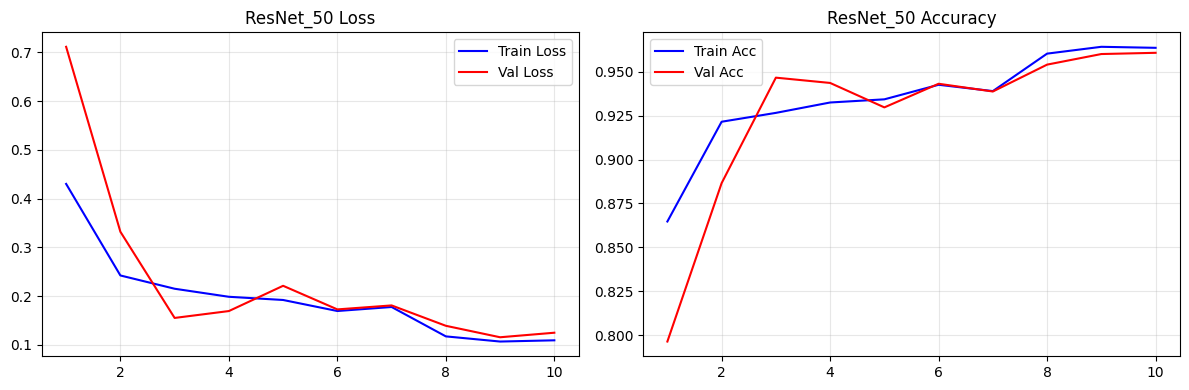

Evaluating ResNet_50: 100%|██████████| 85/85 [00:18<00:00,  4.58it/s]


Overall Accuracy: 0.9637
ResNet-50 Test Accuracy: 0.9637


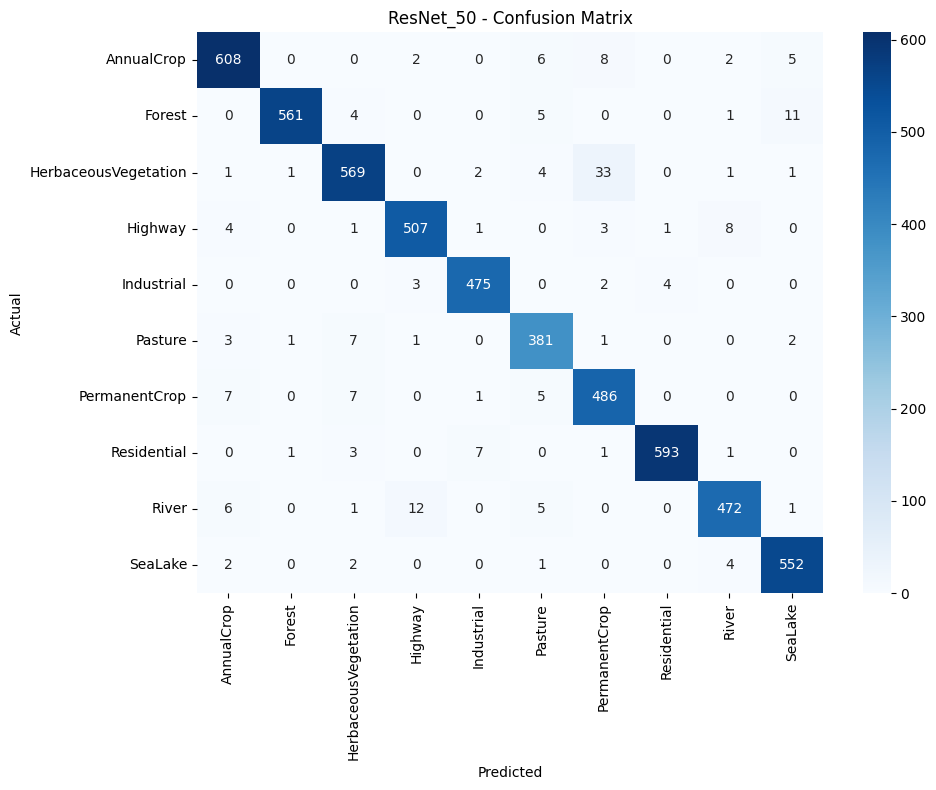

Model saved to resnet50_eurosat.pth


In [ ]:
#   ResNet-50   
model_res = create_transfer_learning_model('resnet50', num_classes=num_classes_eff, pretrained=True)

trained_res, history_res = train_model_eff(
    model=model_res,
    train_loader=train_loader_eff,
    val_loader=val_loader_eff,
    num_epochs=EPOCHS_EFF,
    device=device,
    model_name='ResNet_50',
    lr=LEARNING_RATE_EFF
)
plot_history_eff(history_res, 'ResNet_50')

#    
acc_res, y_pred_res, y_true_res = evaluate_eff(trained_res, test_loader_eff, device, class_names_eff, 'ResNet_50')
print(f'ResNet-50 Test Accuracy: {acc_res:.4f}')

#  
plot_confusion_eff(y_true_res, y_pred_res, class_names_eff, 'ResNet_50')

#  
save_path_res = 'resnet50_eurosat.pth'
torch.save(trained_res.state_dict(), save_path_res)
print('Model saved to', save_path_res)

# Summary
- **We tried ML first** using simple features (color histograms) on a small sample.
- **Results were not ideal** because these features don’t capture complex spatial patterns in satellite imagery.
- **We used Deep Learning** with CNNs/transfer learning on the same data and achieved significantly better results.
- You can expand the experiment by turning off `FAST_DEMO` and training on more samples and epochs to get stronger results.